In this notebook, we will discuss about the Fisher information analysis as a method to quantify parametric uncertainty.
Note that this is a local method.

Recall that we will use the following notations:
* $y \in \mathbb{R}^M$ are the observed data,
* $f(\theta; t)$ is the parameterized model,
* $\theta \in \mathbb{R}^N$ are the parameters of the model,
* $t$ are the independent variables corresponding to the data,
* $M$ and $N$ are the number of data points (and model output) and parameters, respectively.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline
plt.style.use("default")

# Definition

The Fisher information matrix (FIM) measures the information that the data carries about the parameters of the model.
It is defined as
\begin{equation}
    \mathcal{I}(\theta) = -E_y \left[ \frac{\partial^2 \log \mathcal{L}(\theta|y)}{\partial \theta^2} \middle| \theta\right]
    = E_y \left[ \left( \frac{\partial \log \mathcal{L}(\theta|y)}{\partial \theta} \right)^2 \middle| \theta\right],
\end{equation}
where $E_y[\cdot]$ denotes the expectation value over the probability of the data $y$, $P(y)$[^1], and the evaluation point is taken to be the best fit parameters (or the maximum likelihood estimator).
With the special case of a least-squares problem, this equation is simplified to
\begin{equation}
    \mathcal{I}(\theta) = J(\theta)^T W J(\theta),
\end{equation}
where
\begin{equation}
    J(\theta)_{mn} = \frac{\partial f(\theta; t_m)}{\partial \theta_n} \bigg|_\theta
\end{equation}
is the Jacobian matrix and $W$ is the diagonal matrix containing the weights of the data in the least-squares problem,
\begin{equation}
    \text{diag}(W) =
        \begin{bmatrix}
            \sigma_0^{-2} & \sigma_1^{-2} & \cdots \sigma_{M-1}^{-2}
        \end{bmatrix}.
\end{equation}

As an alternative, the FIM can also be calculated using the residual function as
\begin{equation}
    \mathcal{I}(\theta) = J_r(\theta)^T J_r(\theta),
\end{equation}
where
\begin{equation}
    \left(J_r(\theta)\right)_{mn} = \frac{1}{\sigma_m} \frac{\partial f(\theta; t_m)}{\partial \theta_n},
\end{equation}
and the expression on the right-hand side is obtained from taking the derivative of the residual function.




[^1]: The following YouTube [video](https://youtu.be/pneluWj-U-o) shows where this equation comes from using simple examples.

Before computing the FIM, let's define the model.
In this example, we will still use the fractional model.

In [2]:
from model import FractionalModel
import scipy.optimize as scopt

In [3]:
# Define the model
t = np.array([0.1, 1.0, 1.1])
data = np.array([10.0, 0.7, 0.7])
data_error = 0.1 * data


def transform(theta):
    """Parameter transformation function phi."""
    return np.exp(theta)


model = FractionalModel(N=2, t=t, data=data, data_error=data_error, transform=transform)

In [4]:
# Train the model
opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
bestfit = opt.x
print(opt)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 5.796e-03 -7.197e-01  8.986e-01]
           x: [-2.763e+00 -1.311e+00]
        cost: 0.6627336391269714
         jac: [[ 6.303e+00  2.692e+00]
               [ 5.076e-01  2.168e+00]
               [ 3.659e-01  1.719e+00]]
        grad: [ 9.116e-09 -1.049e-07]
  optimality: 1.0491659953720616e-07
 active_mask: [0 0]
        nfev: 24
        njev: None


Let's compute the FIM by taking numerical derivative of the residual function.

In [5]:
import numdifftools as nd

In [6]:
jmodel = nd.Jacobian(model.residual)
Jr = jmodel(bestfit)
I = Jr.T @ Jr
print(I)

[[40.11855369 18.69987355]
 [18.69987355 14.90658281]]


# Interpretation

The FIM gives an approximation to the covariance matrix around the MLE,
\begin{equation}
    \text{Cov}(\theta) \approx \mathcal{I}(\theta)^{-1}.
\end{equation}

Additionally, the FIM also describe the local shape of the cost (or likelihood) surface.
Around the best fit (or MLE), the contours on the cost surface look like ellipses.
The eigenvectors of the FIM describe the orientation of these ellipses, while the eigenvalues are related to the size of the ellipses.

To understand this interpretation, let's look at the FIM of our toy model and its eigenvalues and eigenvectors.

In [7]:
# Generate data to plot the cost surface
params_list = np.linspace(-6, 2, 100)
P0, P1 = np.meshgrid(params_list, params_list)  # Parameter grid

COST = np.zeros_like(P0)
for ii in range(len(params_list)):
    for jj in range(len(params_list)):
        params = np.array([P0[ii, jj], P1[ii, jj]])
        COST[ii, jj] = model.cost(params)

In [8]:
# Eigenvalue decomposition of the FIM
eigvals, eigvecs = np.linalg.eigh(I)
print(eigvals)

[ 4.96049208 50.06464442]


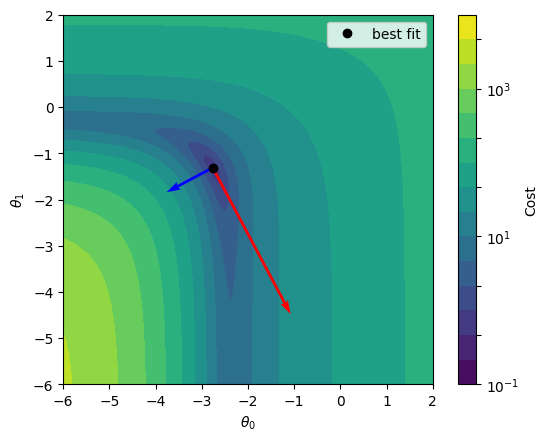

In [9]:
# Plot the eigenvectors of the FIM on top of the cost surface. The vectors are scaled
# by 1/sqrt(lambda).
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 4, 16)
)
clb = plt.colorbar(im)
plt.plot(*bestfit, "ko", label="best fit")

cvecs = ["red", "blue"]
for lam, v, c in zip(eigvals, eigvecs.T, cvecs):
    scale = np.sqrt(lam)
    plt.quiver(*bestfit, *v, scale=scale, color=c)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.gca().set_aspect(1)
plt.legend()
plt.show()

The blue arrow is the eigenvector first eigenvector, $\vec{v}_0$, corresponding to the largest eigenvalue, $\lambda_0$.
The lengths of these eigenvectors are
\begin{equation}
    \Vert \vec{v}_n \Vert = \frac{1}{\sqrt{\lambda_n}}.
\end{equation}

Notice that perturbation in the $\vec{v}_0$ direction leads to the most significant change in the model output.
This is the sensitive or stiff parameter direction.
Where $\vec{v}_1$ shows the insensitive or sloppy parameter combination.
The stiff parameter also shows that the data contains a lot of information about this parameter, thus the data are able to well constrain this parameter.
Thus, the size of the ellipses (and thus the magnitude of the eigenvalues of the FIM) shows both the uncertainty of the parameters and the information that the data carries about the parameters.

Additional note:  
The FIM analysis done so far is considered as a frequentist analysis since there is no information about prior knowledge of the parameters used.
However, there is a modification that is often done to make it a Bayesian analysis by using the posterior distribution instead of the likelihood function in the calculation.